In [1]:
# import nltk
# nltk.download('all')

In [2]:
# 過去に作成されたコーパス(corpus.pickle, filename.pickle)が存在する場合、そのデータを使用します。
USE_DUMPED_CORPUS = True
# 評対象のpdf数の最大値(0の場合は制限なし)
LIMITNUM = 0
# dataフォルダ以下のpdfを再起的に探索するかどうか
RECURSIVE = True

In [3]:
from src.utility import Utility as util
import os
import tqdm.notebook 
import pickle
import sentence_transformers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def preprocess(texts):
    """
    テキストのリストに対して処理を行い、その結果のリストを返します。

    処理内容：
        空の文字列の要素はPDFでの空行であるとみなします。
        空の文字列要素に当たるまでの要素は１つの文章の１部とみなして結合します。
        数字は全て0に置き換えます。
        文章としては不自然な単語数や文字数の単語を含んでいる文章は除外します。
    """
    result = []
    connect_next_text = False
    for text in texts:
        if connect_next_text:
            result[-1] = util.connect_texts(result[-1], util.convert_number_to_word(text, word='0'))
        else:
            result.append(util.convert_number_to_word(text, '0'))
        connect_next_text = not util.is_invalid_text(text)
    return list(filter(lambda x: not util.is_invalid_text(x, ch_lowerlimit=3, word_lowerlimit=3), result))

In [5]:
def save_corpus(corpus, filenames):
    """
    コーパスの作成に時間がかかるので、
    """
    with open('corpus.pickle', 'wb') as fout:
        pickle.dump(corpus, fout)
        print('Dump corpus as corpus.pickle.')
    with open('filename.pickle', 'wb') as fout:
        pickle.dump(filenames, fout)
        print('Dump filenames as filename.pickle.')

def load_corpus():
    corpus = None
    filename = None
    with open('corpus.pickle', 'rb') as fin:
        corpus = pickle.load(fin)

    with open('filename.pickle', 'rb') as fin:
        filename = pickle.load(fin)
    return corpus, filename

def generate_corpus(limit, recursive, save_data=True):
    """
    pdfのファイルを収集してコーパスとファイル名のリストを返します。
    save_dataがTrueの場合は、コーパスの作成後に結果をファイルに保存します。
    """
    corpus = []
    filenames = []
    for pdf_path in tqdm.notebook.tqdm(util.get_pdflist('data', limit=limit, recursive=recursive)):
        text = ' '.join(preprocess(util.load_pdf_texts(pdf_path)))
        corpus.append(text)
        filenames.append(os.path.basename(pdf_path))
    if save_data:
        save_corpus(corpus, filenames)
    return corpus, filenames

In [6]:
if USE_DUMPED_CORPUS:
    corpus, filenames = load_corpus()
else:
    corpus, filenames = generate_corpus(LIMITNUM, RECURSIVE)

In [7]:
# 新しいモデルを使用した場合、初回ののみモデルのダウンロードが始まります。
models = {
    "paraphrase": sentence_transformers.SentenceTransformer('paraphrase-distilroberta-base-v1'),
    "bert": sentence_transformers.SentenceTransformer('bert-base-wikipedia-sections-mean-tokens'),
    "roberta": sentence_transformers.SentenceTransformer('roberta-large-nli-stsb-mean-tokens'),
    "stsb": sentence_transformers.SentenceTransformer('stsb-roberta-large')
}

sentence_embeddings = {}
for model in tqdm.notebook.tqdm(models):
    sentence_embeddings[model] = models[model].encode(corpus)

In [8]:
def cossim(v1, v2):
    """
    コサイン類似度
    """
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)

In [9]:
score_ast = {model: [] for model in models}
score_ml = {model: [] for model in models}
score_bio = {model: [] for model in models}
for model in tqdm.notebook.tqdm(models):
    for i in range(len(sentence_embeddings[model])):
        score = cossim(sentence_embeddings[model][0], sentence_embeddings[model][i])
        if 'bio' in filenames[i]:
            score_bio[model].append(score)
        elif 'ml' in filenames[i]:
            score_ml[model].append(score)
        elif 'ast' in filenames[i]:
            score_ast[model].append(score)
        else:
            pass

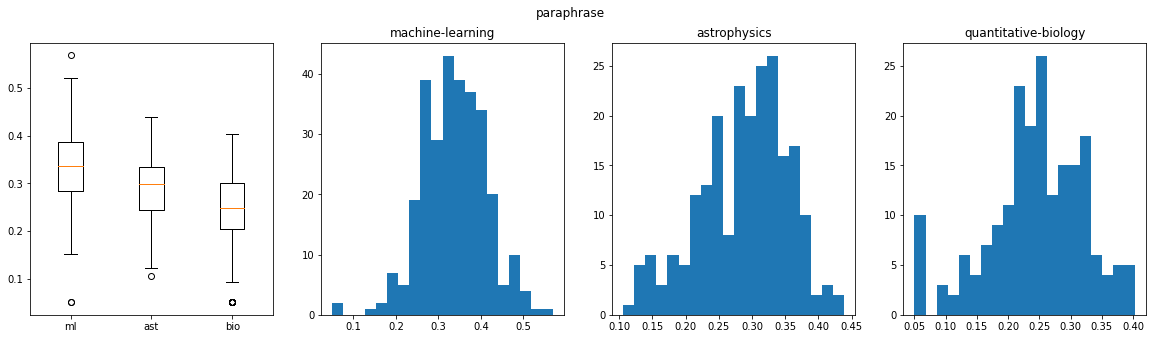

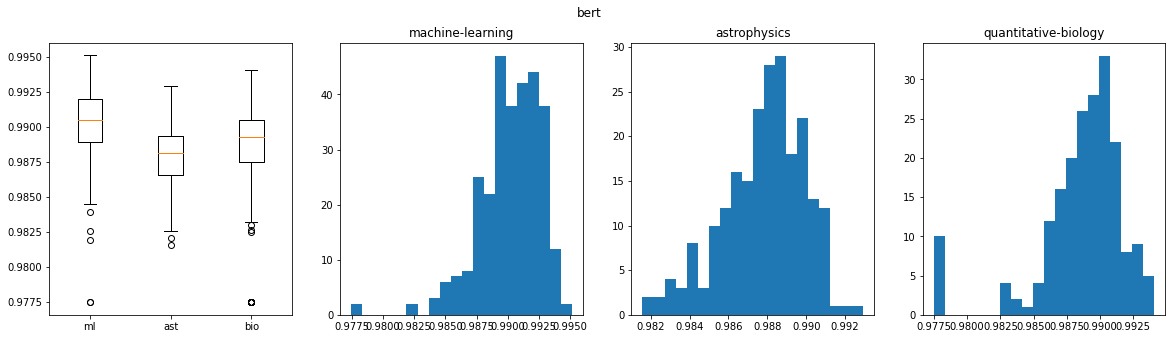

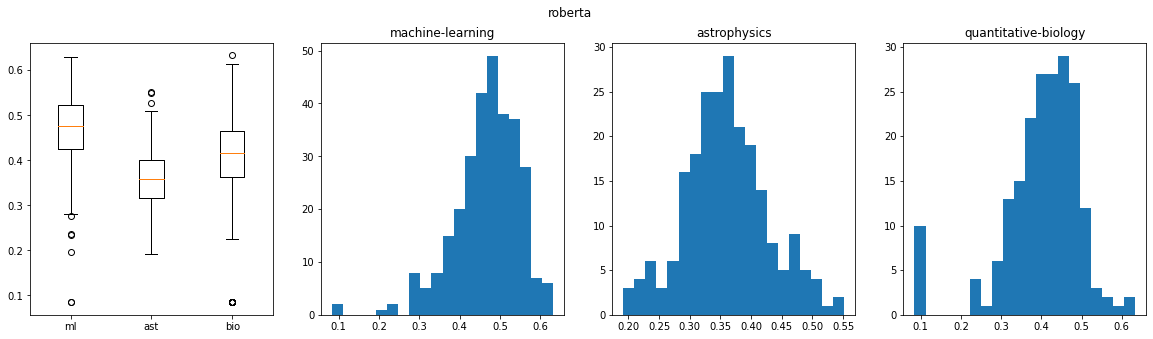

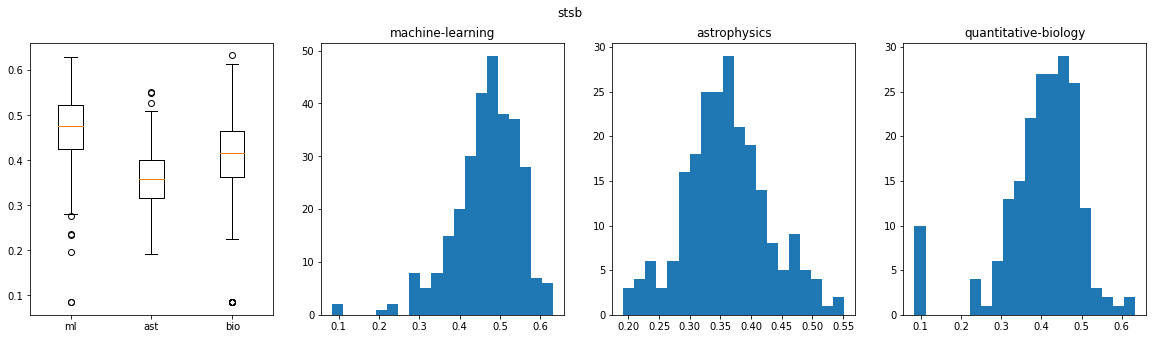

In [15]:
for num, model in enumerate(models):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(model)
    ax[0].boxplot((score_ml[model], score_ast[model], score_bio[model]), labels=["ml", "ast", "bio"])
    ax[1].set_title('machine-learning')
    ax[1].hist(score_ml[model], bins=20)
    ax[2].set_title('astrophysics')
    ax[2].hist(score_ast[model], bins=20)
    ax[3].set_title('quantitative-biology')
    ax[3].hist(score_bio[model], bins=20)
    plt.show()

In [12]:
# save csv
for model in models:
    df = pd.DataFrame()
    max_length = max(len(score_ml[model]), len(score_ast[model]), len(score_bio[model]))
    df["machine-learning"] = score_ml[model] + [np.nan] * (max_length - len(score_ml[model]))
    df["astrophysics"] = score_ast[model] + [np.nan] * (max_length - len(score_ast[model]))
    df["quantitative-biology"] = score_bio[model] + [np.nan] * (max_length - len(score_bio[model]))
    df.to_csv(f'result_{model}.csv', index=False)


# 有意性の検定

## 1. 正規性の検定
まずは、各分布が正規分布にしたがっているかどうかを確認します。
検定にはシャピロ・ウィルクの検定を行います。

以下はRでP値を計算した結果ですが、多重検定を行っているためボンフェローニ法に従い実際の有意水準は0.05/9=0.0056で行います。
すると、得られた分布はガウス分布にしたがっていない可能性が高いことがわかります。


<table>
<tr><td>モデル</td><td>machine-learning</td><td>astrophysics</td><td>quantitative-biology</td></tr>
<tr><td>bert</td><td>6.285e-11</td><td>2.093e-4</td><td>1.094e-13</td></tr>
<tr><td>paraphrase</td><td>1.821e-2</td><td>9.730e-4</td><td>1.732e-4</td></tr>
<tr><td>roberta</td><td>1.753e-9</td><td>2.372e-1</td><td>2.437e-11</td></tr>
<tr><td>stsb</td><td>1.753e-9</td><td>2.372e-1</td><td>2.437e-11</td></tr>
</table>


## 2. 有意性検定
得られた平均値の差がモデルの差による場合か、ばらつきの範囲ないかを検定します。

ガウス分布にしたがっていない可能性が高いので、ノンパラメトリックによる分散分析を行います。
今回はクラスカル・ウォリス検定を行いました。

結果を見てわかる様に、帰無仮説が採択されますので有意の差があるとみなせます。

<table>
<tr><td>モデル</td><td>p値</td></tr>
<tr><td>bert</td><td>2.2e-16以下</td></tr>
<tr><td>paraphrase</td><td>2.2e-16以下</td></tr>
<tr><td>roberta</td><td>2.2e-16以下</td></tr>
<tr><td>stsb</td><td>2.2e-16以下</td></tr>
</table>

## 3. 多重比較

<table>
<tr><td>モデル</td><td>machine vs astro</td><td>machine vs bio</td><td> vastro vs bio</td></tr>
<tr><td>bert</td><td>0</td><td>0.9104</td><td>0</td></tr>
<tr><td>paraphrase</td><td>0</td><td>0</td><td>1.732e-4</td></tr>
<tr><td>roberta</td><td>0</td><td>0</td><td>3.125e-11</td></tr>
<tr><td>stsb</td><td>0</td><td>0</td><td>3.125e-11</td></tr>
</table>



# 結論
paraphrase, roberta, stsbでは類似性を計算できている傾向がある。
ただし、ばらつきも大きいので実用するためにはモデルのチューニングが必要である。

## 疑問
- roberta-large-nli-stsb-mean-tokensとstsb-roberta-largeの２つのモデルで結果が全く同じになっていること。
- 分散分析と多重比較のp値が極端に低いこと。計算方法を再確認した方が良さそう。